In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sp

# Preprocessing

Data was obtained from [github](https://github.com/syam-s/maziarraissi).

There are $n$ unique pairs of spatial co-ordinates $(x, y)$ and $T$ unique temporal co-ordinates $t$. We require $nT$ inputs to account for every unique combination of $(x, y)$ and $t$. To achieve this we duplicate each $x$ and $y$ co-ordinate $T$ times and duplicate each $t$ aco-ordinate $n$ times such that each row index $i \in (1, ...,nT)$ corresponds to a unique combination of $(x, y, t).$

In [6]:
data = sp.loadmat('cylinder_wake.mat')

x_data = data['X_star'][:, 0:1] # n
y_data = data['X_star'][:, 1:2] # n
t_data = data['t'] # T
u_data = data['U_star'][:, 0, :] # n x T
v_data = data['U_star'][:, 1, :] # n x T
p_data = data['p_star'] # n x T

n = x_data.shape[0]
T = t_data.shape[0]

# duplicate x and y for each t
x = np.tile(x_data, (1, T)).reshape((-1, 1))
y = np.tile(y_data, (1, T)).reshape((-1, 1))

# duplicate t for each pair (x, y)
t = np.tile(t_data, (1, n)).T.reshape((-1, 1))

u = u_data.reshape((-1, 1))
v = v_data.reshape((-1, 1))
p = p_data.reshape((-1, 1))

# convert to tensors
x_test = tf.constant(x, dtype=tf.float32)
y_test = tf.constant(y, dtype=tf.float32)
t_test = tf.constant(t, dtype=tf.float32)
u_test = tf.constant(u, dtype=tf.float32)
v_test = tf.constant(v, dtype=tf.float32)
p_test = tf.constant(p, dtype=tf.float32)

# select 5000 random points for training
train_idx = np.random.choice(n * T, 5000, replace=False)
x_train = x[train_idx, :]
y_train = y[train_idx, :]
t_train = t[train_idx, :]
u_train = u[train_idx, :]
v_train = v[train_idx, :]
p_train = p[train_idx, :]

# convert to tensors
x_train = tf.constant(x_train, dtype=tf.float32)
y_train = tf.constant(y_train, dtype=tf.float32)
t_train = tf.constant(t_train, dtype=tf.float32)
u_train = tf.constant(u_train, dtype=tf.float32)
v_train = tf.constant(v_train, dtype=tf.float32)
p_train = tf.constant(p_train, dtype=tf.float32)

Create a gif of the experimental data.

In [40]:
import matplotlib.animation as animation

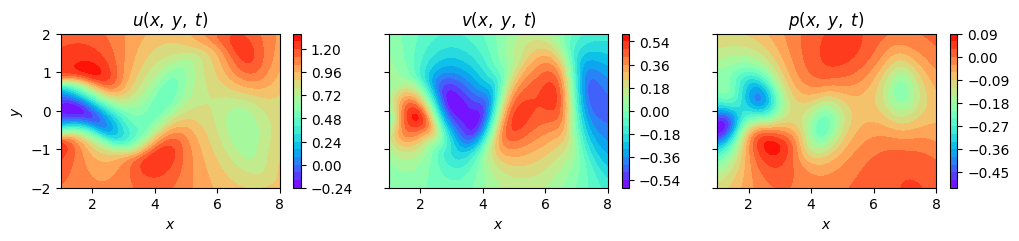

In [ ]:

fig, ax = plt.subplots(1, 3, figsize=(12, 2), sharey=True)

x_plot = x_data.reshape((50, 100))
y_plot = y_data.reshape((50, 100))

u_plot = u_data[:, 0].reshape((50, 100))
plot = ax[0].contourf(x_plot, y_plot, u_plot, levels=20, cmap='rainbow')
fig.colorbar(plot, ax=ax[0])
ax[0].set_title("$u(x,\; y, \; t)$")
ax[0].set_xlabel("$x$")
ax[0].set_ylabel("$y$")

v_plot = v_data[:, 0].reshape((50, 100))
plot = ax[1].contourf(x_plot, y_plot, v_plot, levels=20, cmap='rainbow')
fig.colorbar(plot, ax=ax[1])
ax[1].set_title("$v(x,\; y, \; t)$")
ax[1].set_xlabel("$x$")

p_plot = p_data[:, 0].reshape((50, 100))
plot = ax[2].contourf(x_plot, y_plot, p_plot, levels=20, cmap='rainbow')
fig.colorbar(plot, ax=ax[2])
ax[2].set_title("$p(x,\; y, \; t)$")
ax[2].set_xlabel("$x$")

def animate(i):
    u_plot = u_data[:, i].reshape((50, 100))
    plot = ax[0].contourf(x_plot, y_plot, u_plot, levels=20, cmap='rainbow')
    #fig.colorbar(plot, ax=ax[0])
    ax[0].set_title("$u(x,\; y, \; t)$")
    ax[0].set_xlabel("$x$")
    ax[0].set_ylabel("$y$")

    v_plot = v_data[:, 0].reshape((50, 100))
    plot = ax[1].contourf(x_plot, y_plot, v_plot, levels=20, cmap='rainbow')
    #fig.colorbar(plot, ax=ax[1])
    ax[1].set_title("$v(x,\; y, \; t)$")
    ax[1].set_xlabel("$x$")

    p_plot = p_data[:, 0].reshape((50, 100))
    plot = ax[2].contourf(x_plot, y_plot, p_plot, levels=20, cmap='rainbow')
    #fig.colorbar(plot, ax=ax[2])
    ax[2].set_title("$p(x,\; y, \; t)$")
    ax[2].set_xlabel("$x$")

ani = animation.FuncAnimation(fig, animate, 100, interval=1, blit=False)
ani.save('cylinder_wake_data.gif')

First we eneed to define a neural network that incorporates $\rho$ and $\mu$ as trainable parameters.

In [7]:
class NN_discovery(tf.keras.Sequential):

    def __init__(self):
        super().__init__()
        self.rho = tf.Variable(initial_value=1.0, trainable=True) # density
        self.mu = tf.Variable(initial_value=1.0, trainable=True)  # viscosity


Now we can define the PINN that will be trained to learn the values of $\rho$ and $\mu$. The model will have three input parameters $(x, y, t)$ and three output parameters $(u, v, p)$ representing velocity in the $x$ and $y$ direction and the pressure of the fluid flow. The loss function is given by:

In [32]:
class PINN_navier_stokes:

    def __init__(self, x, y, t, u, v, p, layers):

        # parameters
        self.rho = 1.0
        self.mu = 0.02

        self.x = x
        self.y = y
        self.t = t
        self.u = u
        self.v = v
        self.p = p

        # neural network
        self.neural_net = self.initialize_neural_net(layers)
        self.optimizer = tf.keras.optimizers.Adam(5e-4)
        self.history = []

    def initialize_neural_net(self, layers):
        neural_net = NN_discovery()

        # input layer
        neural_net.add(tf.keras.layers.Input(shape=(3, )))

        # hidden layers
        for neurons in layers:
            neural_net.add(tf.keras.layers.Dense(neurons, activation='tanh'))

        # output layer
        neural_net.add(tf.keras.layers.Dense(3))

        return neural_net

    def predict(self, x, y, t):

        with tf.GradientTape(persistent=True) as tape:
            tape.watch((x, y))

            inputs = tf.concat((x, y, t), axis=1)
            prediction = self.neural_net(inputs)
            psi = prediction[:, 0:1] # streamfunction

        # velocity
        u = tape.gradient(psi, y)
        v = -tape.gradient(psi, x)

        # pressure
        p = prediction[:, 1:2]

        return u, v, p


    def train(self, epochs):

        for epoch in range(1, epochs - 1):
            with tf.GradientTape() as tape:
                loss = self.loss()

            gradients = tape.gradient(loss, self.neural_net.trainable_variables)
            self.optimizer.apply_gradients(zip(gradients, self.neural_net.trainable_variables))

            self.history.append(loss.numpy())
            print(f"epoch: {epoch} loss: {loss}")


    def loss(self):

        # calculate derivatives
        with tf.GradientTape(persistent=True) as tape1:
            tape1.watch((self.x, self.y))

            with tf.GradientTape(persistent=True) as tape2:
                tape2.watch((self.x, self.y, self.t))
                u, v, p = self.predict(self.x, self.y, self.t)

            # first derivatives
            u_x = tape2.gradient(u, self.x)
            u_y = tape2.gradient(u, self.y)
            u_t = tape2.gradient(u, self.t)
            v_x = tape2.gradient(v, self.x)
            v_y = tape2.gradient(v, self.y)
            v_t = tape2.gradient(v, self.t)
            p_x = tape2.gradient(p, self.x)
            p_y = tape2.gradient(p, self.y)

        # second derivatives
        u_xx = tape1.gradient(u_x, self.x)
        u_yy = tape1.gradient(u_y, self.y)
        v_xx = tape1.gradient(v_x, self.x)
        v_yy = tape1.gradient(v_y, self.y)


        # navier stokes equations
        f_u = self.neural_net.rho * (u_t + u * u_x + v * u_y) + p_x - self.neural_net.mu * (u_xx + u_yy)
        f_v = self.neural_net.rho * (v_t + u * v_x + v * v_y) + p_y - self.neural_net.mu * (v_xx + v_yy)


        physics_loss = tf.reduce_mean(tf.square(f_u)) \
                     + tf.reduce_mean(tf.square(f_v))

        data_loss = tf.reduce_mean(tf.square(u - self.u)) \
                  + tf.reduce_mean(tf.square(v - self.v)) \
                  + tf.reduce_mean(tf.square(p - self.p))

        return data_loss + physics_loss


In [33]:
layers = 8 * [40]
PINN = PINN_navier_stokes(x_train, y_train, t_train, u_train, v_train, p_train, layers)

In [34]:
PINN.loss()

<tf.Tensor: shape=(), dtype=float32, numpy=1.1805764>

In [35]:
with tf.device('/device:GPU:0'):
    PINN.train(30_000)

Streaming output truncated to the last 5000 lines.
epoch: 25015 loss: 0.0006555258296430111
epoch: 25016 loss: 0.0006555322324857116
epoch: 25017 loss: 0.0006555545260198414
epoch: 25018 loss: 0.0006555994623340666
epoch: 25019 loss: 0.0006556788575835526
epoch: 25020 loss: 0.000655806390568614
epoch: 25021 loss: 0.0006560055771842599
epoch: 25022 loss: 0.0006563056376762688
epoch: 25023 loss: 0.0006567515665665269
epoch: 25024 loss: 0.0006574119906872511
epoch: 25025 loss: 0.000658384757116437
epoch: 25026 loss: 0.0006598205654881895
epoch: 25027 loss: 0.0006619456107728183
epoch: 25028 loss: 0.0006651029689237475
epoch: 25029 loss: 0.0006698186043649912
epoch: 25030 loss: 0.0006768855964764953
epoch: 25031 loss: 0.0006875328253954649
epoch: 25032 loss: 0.0007035910966806114
epoch: 25033 loss: 0.0007278692210093141
epoch: 25034 loss: 0.0007643817225471139
epoch: 25035 loss: 0.0008190152002498507
epoch: 25036 loss: 0.0008991207578219473
epoch: 25037 loss: 0.001013749511912465
epoch: 25

KeyboardInterrupt: 

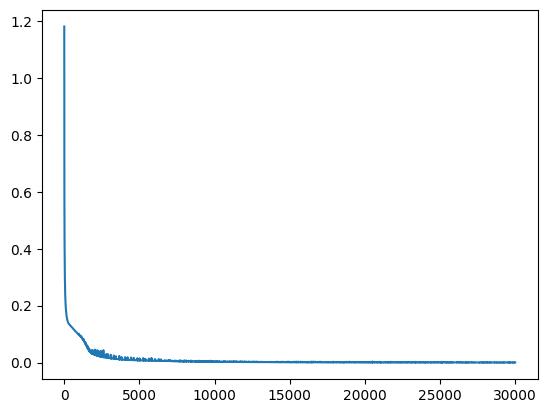

In [36]:
plt.plot(PINN.history)

In [37]:
def relative_error(x_pred, x_true):
    return tf.math.sqrt(tf.reduce_sum(tf.square(x_pred - x_true))) / tf.math.sqrt(tf.reduce_sum(tf.square(x_true)))

In [38]:
u_pred, v_pred, p_pred = PINN.predict(x_test, y_test, t_test)

print("Relative Error")
print(f"u: {relative_error(u_pred, u_test)}")
print(f"v: {relative_error(v_pred, v_test)}")
print(f"p: {relative_error(p_pred, p_test)}")
print(f"\u03C1: {relative_error(PINN.neural_net.rho, 1.0)}")
print(f"\u03BC: {relative_error(PINN.neural_net.mu, 0.02)}")

Relative Error
u: 0.013428601436316967
v: 0.03776770830154419
p: 0.052734628319740295
ρ: 0.0681908130645752
μ: 0.486273854970932


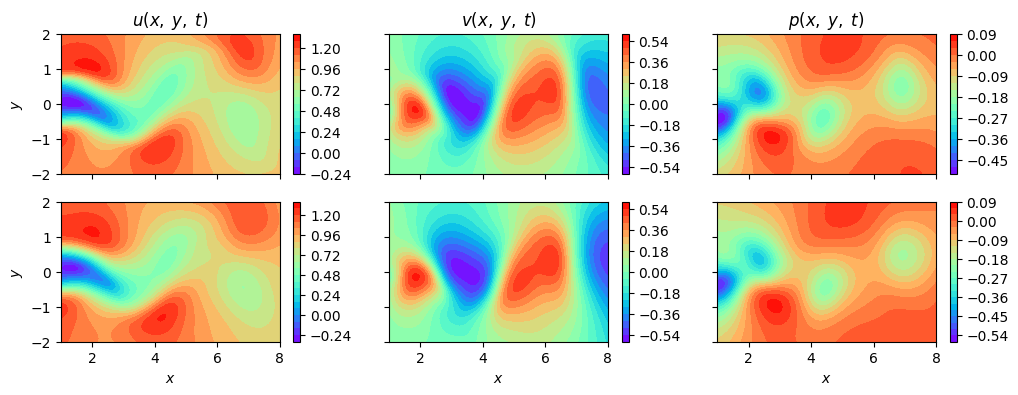

In [43]:
u_pred = tf.reshape(u_pred, shape=(n, T))
v_pred = tf.reshape(v_pred, shape=(n, T))
p_pred = tf.reshape(p_pred, shape=(n, T))

fig, ax = plt.subplots(2, 3, figsize=(12, 4), sharex=True, sharey=True)

x_plot = x_data.reshape((50, 100))
y_plot = y_data.reshape((50, 100))

u_plot = u_data[:, 0].reshape((50, 100))
plot = ax[0, 0].contourf(x_plot, y_plot, u_plot, levels=20, cmap='rainbow')
fig.colorbar(plot, ax=ax[0, 0])
ax[0, 0].set_title("$u(x,\; y, \; t)$")
ax[0, 0].set_ylabel("$y$")

v_plot = v_data[:, 0].reshape((50, 100))
plot = ax[0, 1].contourf(x_plot, y_plot, v_plot, levels=20, cmap='rainbow')
fig.colorbar(plot, ax=ax[0, 1])
ax[0, 1].set_title("$v(x,\; y, \; t)$")

p_plot = p_data[:, 0].reshape((50, 100))
plot = ax[0, 2].contourf(x_plot, y_plot, p_plot, levels=20, cmap='rainbow')
fig.colorbar(plot, ax=ax[0, 2])
ax[0, 2].set_title("$p(x,\; y, \; t)$")

u_plot = tf.reshape(u_pred[:, 0], (50, 100))
plot = ax[1, 0].contourf(x_plot, y_plot, u_plot, levels=20, cmap='rainbow')
fig.colorbar(plot, ax=ax[1, 0])
ax[1, 0].set_xlabel("$x$")
ax[1, 0].set_ylabel("$y$")

v_plot = tf.reshape(v_pred[:, 0], (50, 100))
plot = ax[1, 1].contourf(x_plot, y_plot, v_plot, levels=20, cmap='rainbow')
fig.colorbar(plot, ax=ax[1, 1])
ax[1, 1].set_xlabel("$x$")

p_plot = tf.reshape(p_pred[:, 0], (50, 100))
plot = ax[1, 2].contourf(x_plot, y_plot, p_plot, levels=20, cmap='rainbow')
fig.colorbar(plot, ax=ax[1, 2])
ax[1, 2].set_xlabel("$x$")

fig.savefig("cylinder_wake_adam.png")

def animate(i):
    u_plot = u_data[:, i].reshape((50, 100))
    plot = ax[0, 0].contourf(x_plot, y_plot, u_plot, levels=20, cmap='rainbow')
    #fig.colorbar(plot, ax=ax[0, 0])
    ax[0, 0].set_title("$u(x,\; y, \; t)$")
    ax[0, 0].set_ylabel("$y$")

    v_plot = v_data[:, i].reshape((50, 100))
    plot = ax[0, 1].contourf(x_plot, y_plot, v_plot, levels=20, cmap='rainbow')
    #fig.colorbar(plot, ax=ax[0, 1])
    ax[0, 1].set_title("$v(x,\; y, \; t)$")

    p_plot = p_data[:, i].reshape((50, 100))
    plot = ax[0, 2].contourf(x_plot, y_plot, p_plot, levels=20, cmap='rainbow')
    #fig.colorbar(plot, ax=ax[0, 2])
    ax[0, 2].set_title("$p(x,\; y, \; t)$")

    u_plot = tf.reshape(u_pred[:, i], (50, 100))
    plot = ax[1, 0].contourf(x_plot, y_plot, u_plot, levels=20, cmap='rainbow')
    #fig.colorbar(plot, ax=ax[1, 0])
    ax[1, 0].set_xlabel("$x$")
    ax[1, 0].set_ylabel("$y$")

    v_plot = tf.reshape(v_pred[:, i], (50, 100))
    plot = ax[1, 1].contourf(x_plot, y_plot, v_plot, levels=20, cmap='rainbow')
    #fig.colorbar(plot, ax=ax[1, 1])
    ax[1, 1].set_xlabel("$x$")

    p_plot = tf.reshape(p_pred[:, i], (50, 100))
    plot = ax[1, 2].contourf(x_plot, y_plot, p_plot, levels=20, cmap='rainbow')
    #fig.colorbar(plot, ax=ax[1, 2])
    ax[1, 2].set_xlabel("$x$")

ani = animation.FuncAnimation(fig, animate, 100, interval=1, blit=False)
ani.save('cylinder_wake_adam.gif')

# L-BFGS Algorithm

The Adam optimizer is not able to effectively minimise the loss function in this case. Instead we can can use the L-BFGS algorithm to find the set of weights and biases that minimises the loss function

Tensorflow does not have an optimizer based on the L-BFGS algorithm. Instead we need constuct a workaround using the lbfgs_minimise() function from the Tensorflow probability library. This function requires two arguments; a value and gradients function based on the function we wish to minimise and an initial input. The algorithm then finds argument that minimise the value and gradients function.

In the context of a PINN, a value and gradients function based on the loss function must be constructed. The loss function of the neural network minimised by adjusting the weights and biases. So the value and gradients loss function needs to take in the network parameters (weights and biases) as an argument.

In [44]:
import tensorflow_probability as tfp

class PINN_navier_stokes_lbfgs:

    def __init__(self, x, y, t, u, v, p, layers):

        # parameters
        #self.rho = 1.0
        #self.mu = 0.02

        self.x = x
        self.y = y
        self.t = t
        self.u = u
        self.v = v
        self.p = p

        # neural network
        self.neural_net = self.initialize_neural_net(layers)
        self.iter = tf.Variable(0)
        self.history = []

        self.shapes = tf.shape_n(self.neural_net.trainable_variables)
        self.n_tensors = len(self.shapes) # number of weight matrices

        count = 0
        self.idx = [] # stitch indices
        self.part = [] # partition indices

        for i, shape in enumerate(self.shapes):
            n = np.prod(shape) # number of elements in weight matrix
            self.idx.append(tf.reshape(tf.range(count, count+n, dtype=tf.int32), shape))
            self.part.extend([i]*n)
            count += n

        self.part = tf.constant(self.part)

    def initialize_neural_net(self, layers):
        neural_net = NN_discovery()

        # input layer
        neural_net.add(tf.keras.layers.Input(shape=(3, )))

        # hidden layers
        for neurons in layers:
            neural_net.add(tf.keras.layers.Dense(neurons, activation='tanh'))

        # output layer
        neural_net.add(tf.keras.layers.Dense(3))

        return neural_net

    def predict(self, x, y, t):

        with tf.GradientTape(persistent=True) as tape:
            tape.watch((x, y))

            inputs = tf.concat((x, y, t), axis=1)
            prediction = self.neural_net(inputs)
            psi = prediction[:, 0:1]

        # velocity
        u = tape.gradient(psi, y)
        v = -tape.gradient(psi, x)

        # pressure
        p = prediction[:, 1:2]

        return u, v, p

    # assigns a provided set of weights and biases to the neural network
    @tf.function
    def assign_new_model_parameters(self, params_1d):
        params = tf.dynamic_partition(params_1d, self.part, self.n_tensors)
        for i, (shape, param) in enumerate(zip(self.shapes, params)):
            self.neural_net.trainable_variables[i].assign(tf.reshape(param, shape))

    @tf.function
    def value_and_gradients_loss(self, params_1d):
        with tf.GradientTape() as tape:
            self.assign_new_model_parameters(params_1d)
            loss_value = self.loss()

        grads = tape.gradient(loss_value, self.neural_net.trainable_variables)
        grads = tf.dynamic_stitch(self.idx, grads)

        self.iter.assign_add(1)
        tf.print("Iter:", self.iter, "loss:", loss_value)

        tf.py_function(self.history.append, inp=[loss_value], Tout=[])

        return loss_value, grads

    def train(self, max_iterations):
        init_params = tf.dynamic_stitch(self.idx, self.neural_net.trainable_variables)

        with tf.device('/device:GPU:0'):

            # find the set of weights and biases that minimises the loss using the lbfgs algorithm
            results = tfp.optimizer.lbfgs_minimize(
                value_and_gradients_function=self.value_and_gradients_loss,
                initial_position=init_params,
                max_iterations=max_iterations,
                max_line_search_iterations=50,
                tolerance=0.,
                x_tolerance = 0.,
                f_absolute_tolerance = 0.
            )

        self.assign_new_model_parameters(results.position)


    def loss(self):

        # calculate derivatives
        with tf.GradientTape(persistent=True) as tape1:
            tape1.watch((self.x, self.y))

            with tf.GradientTape(persistent=True) as tape2:
                tape2.watch((self.x, self.y, self.t))
                u, v, p = self.predict(self.x, self.y, self.t)

            # first derivatives
            u_x = tape2.gradient(u, self.x)
            u_y = tape2.gradient(u, self.y)
            u_t = tape2.gradient(u, self.t)
            v_x = tape2.gradient(v, self.x)
            v_y = tape2.gradient(v, self.y)
            v_t = tape2.gradient(v, self.t)
            p_x = tape2.gradient(p, self.x)
            p_y = tape2.gradient(p, self.y)

        # second derivatives
        u_xx = tape1.gradient(u_x, self.x)
        u_yy = tape1.gradient(u_y, self.y)
        v_xx = tape1.gradient(v_x, self.x)
        v_yy = tape1.gradient(v_y, self.y)


        # navier stokes equations
        f_u = self.neural_net.rho * (u_t + u * u_x + v * u_y) + p_x - self.neural_net.mu * (u_xx + u_yy)
        f_v = self.neural_net.rho * (v_t + u * v_x + v * v_y) + p_y - self.neural_net.mu * (v_xx + v_yy)


        physics_loss = tf.reduce_mean(tf.square(f_u)) \
                     + tf.reduce_mean(tf.square(f_v))

        data_loss = tf.reduce_mean(tf.square(u - self.u)) \
                  + tf.reduce_mean(tf.square(v - self.v)) \
                  + tf.reduce_mean(tf.square(p - self.p))

        return physics_loss + data_loss

In [46]:
tf.random.set_seed(0)

# 8 densely conected layers with 40 neurons in each layer
layers = 8 * [40]
PINN_lbfgs = PINN_navier_stokes_lbfgs(x_train, y_train, t_train, u_train, v_train, p_train, layers)
PINN_lbfgs.neural_net.summary()

Model: "nn_discovery_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 40)                160       
                                                                 
 dense_37 (Dense)            (None, 40)                1640      
                                                                 
 dense_38 (Dense)            (None, 40)                1640      
                                                                 
 dense_39 (Dense)            (None, 40)                1640      
                                                                 
 dense_40 (Dense)            (None, 40)                1640      
                                                                 
 dense_41 (Dense)            (None, 40)                1640      
                                                                 
 dense_42 (Dense)            (None, 40)             

In [47]:
PINN_lbfgs.train(100_000)

Streaming output truncated to the last 5000 lines.
Iter: 19976 loss: 0.0159225725
Iter: 19977 loss: 0.0159221776
Iter: 19978 loss: 0.0159215331
Iter: 19979 loss: 0.015920572
Iter: 19980 loss: 0.0159205813
Iter: 19981 loss: 0.015917968
Iter: 19982 loss: 0.0159178823
Iter: 19983 loss: 0.0159175191
Iter: 19984 loss: 0.0159161687
Iter: 19985 loss: 0.0159174576
Iter: 19986 loss: 0.0159151051
Iter: 19987 loss: 0.0159133356
Iter: 19988 loss: 0.0159222446
Iter: 19989 loss: 0.0159130432
Iter: 19990 loss: 0.0159125961
Iter: 19991 loss: 0.0159113444
Iter: 19992 loss: 0.0159197748
Iter: 19993 loss: 0.0159111246
Iter: 19994 loss: 0.0159125309
Iter: 19995 loss: 0.0159094222
Iter: 19996 loss: 0.0159065686
Iter: 19997 loss: 0.0159091745
Iter: 19998 loss: 0.0159048773
Iter: 19999 loss: 0.0158993565
Iter: 20000 loss: 0.0159159042
Iter: 20001 loss: 0.0158978142
Iter: 20002 loss: 0.0158941
Iter: 20003 loss: 0.0159454457
Iter: 20004 loss: 0.0158940591
Iter: 20005 loss: 0.0158928
Iter: 20006 loss: 0.0158926

In [48]:
u_pred, v_pred, p_pred = PINN_lbfgs.predict(x_test, y_test, t_test)

u_mse = tf.reduce_mean(tf.square(u_pred - u_test))
v_mse = tf.reduce_mean(tf.square(v_pred - v_test))
p_mse = tf.reduce_mean(tf.square(p_pred - p_test))

print("Mean Squared Error")
print(f"u: {u_mse}")
print(f"v: {v_mse}")
print(f"p: {p_mse}")
print(f"total: {u_mse + v_mse + p_mse}")

Mean Squared Error
u: 0.003849059110507369
v: 0.005331024527549744
p: 0.00479709729552269
total: 0.013977181166410446


In [49]:
print("Relative Error")
print(f"u: {relative_error(u_pred, u_test)}")
print(f"v: {relative_error(v_pred, v_test)}")
print(f"p: {relative_error(p_pred, p_test)}")
print(f"\u03C1: {relative_error(PINN_lbfgs.neural_net.rho, 1.0)}")
print(f"\u03BC: {relative_error(PINN_lbfgs.neural_net.mu, 0.02)}")

Relative Error
u: 0.06849315762519836
v: 0.26631084084510803
p: 0.5264884233474731
ρ: 0.8563329577445984
μ: 0.8039748668670654


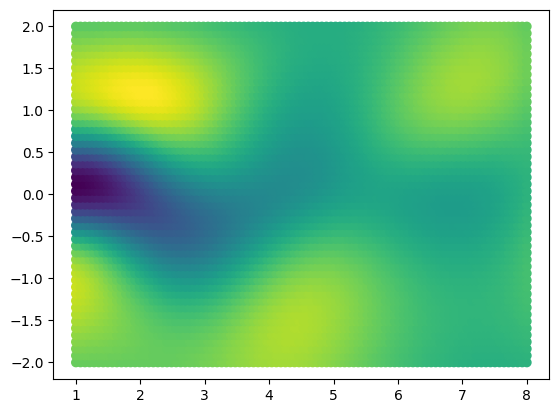

In [30]:
uu = tf.reshape(u_pred, shape=(n, T))

plt.scatter(x_data, y_data, c=uu[:, 1])

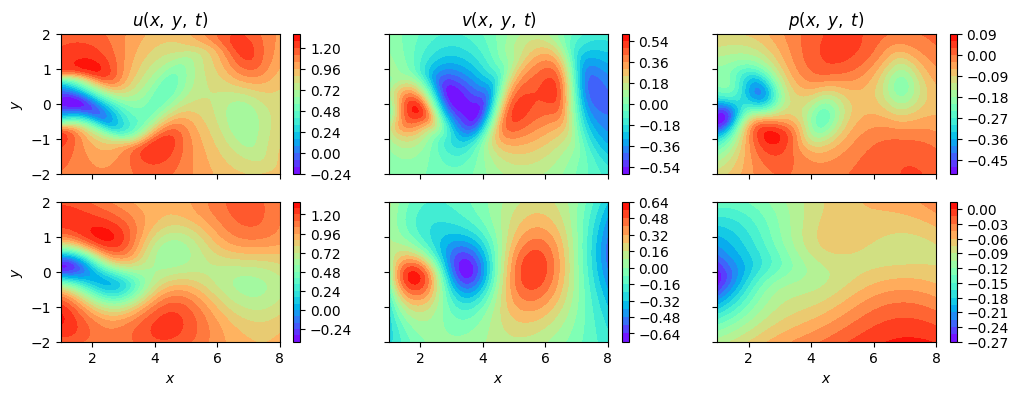

In [52]:
u_pred = tf.reshape(u_pred, shape=(n, T))
v_pred = tf.reshape(v_pred, shape=(n, T))
p_pred = tf.reshape(p_pred, shape=(n, T))

fig, ax = plt.subplots(2, 3, figsize=(12, 4), sharex=True, sharey=True)

x_plot = x_data.reshape((50, 100))
y_plot = y_data.reshape((50, 100))

u_plot = u_data[:, 0].reshape((50, 100))
plot = ax[0, 0].contourf(x_plot, y_plot, u_plot, levels=20, cmap='rainbow')
fig.colorbar(plot, ax=ax[0, 0])
ax[0, 0].set_title("$u(x,\; y, \; t)$")
ax[0, 0].set_ylabel("$y$")

v_plot = v_data[:, 0].reshape((50, 100))
plot = ax[0, 1].contourf(x_plot, y_plot, v_plot, levels=20, cmap='rainbow')
fig.colorbar(plot, ax=ax[0, 1])
ax[0, 1].set_title("$v(x,\; y, \; t)$")

p_plot = p_data[:, 0].reshape((50, 100))
plot = ax[0, 2].contourf(x_plot, y_plot, p_plot, levels=20, cmap='rainbow')
fig.colorbar(plot, ax=ax[0, 2])
ax[0, 2].set_title("$p(x,\; y, \; t)$")

u_plot = tf.reshape(u_pred[:, 0], (50, 100))
plot = ax[1, 0].contourf(x_plot, y_plot, u_plot, levels=20, cmap='rainbow')
fig.colorbar(plot, ax=ax[1, 0])
ax[1, 0].set_xlabel("$x$")
ax[1, 0].set_ylabel("$y$")

v_plot = tf.reshape(v_pred[:, 0], (50, 100))
plot = ax[1, 1].contourf(x_plot, y_plot, v_plot, levels=20, cmap='rainbow')
fig.colorbar(plot, ax=ax[1, 1])
ax[1, 1].set_xlabel("$x$")

p_plot = tf.reshape(p_pred[:, 0], (50, 100))
plot = ax[1, 2].contourf(x_plot, y_plot, p_plot, levels=20, cmap='rainbow')
fig.colorbar(plot, ax=ax[1, 2])
ax[1, 2].set_xlabel("$x$")

fig.savefig("cylinder_wake_lbfgs.png")

def animate(i):
    u_plot = u_data[:, 0].reshape((50, 100))
    plot = ax[0, 0].contourf(x_plot, y_plot, u_plot, levels=20, cmap='rainbow')
    #fig.colorbar(plot, ax=ax[0, 0])
    ax[0, 0].set_title("$u(x,\; y, \; t)$")
    ax[0, 0].set_ylabel("$y$")

    v_plot = v_data[:, 0].reshape((50, 100))
    plot = ax[0, 1].contourf(x_plot, y_plot, v_plot, levels=20, cmap='rainbow')
    #fig.colorbar(plot, ax=ax[0, 1])
    ax[0, 1].set_title("$v(x,\; y, \; t)$")

    p_plot = p_data[:, 0].reshape((50, 100))
    plot = ax[0, 2].contourf(x_plot, y_plot, p_plot, levels=20, cmap='rainbow')
    #fig.colorbar(plot, ax=ax[0, 2])
    ax[0, 2].set_title("$p(x,\; y, \; t)$")

    u_plot = tf.reshape(u_pred[:, 0], (50, 100))
    plot = ax[1, 0].contourf(x_plot, y_plot, u_plot, levels=20, cmap='rainbow')
    #fig.colorbar(plot, ax=ax[1, 0])
    ax[1, 0].set_xlabel("$x$")
    ax[1, 0].set_ylabel("$y$")

    v_plot = tf.reshape(v_pred[:, 0], (50, 100))
    plot = ax[1, 1].contourf(x_plot, y_plot, v_plot, levels=20, cmap='rainbow')
    #fig.colorbar(plot, ax=ax[1, 1])
    ax[1, 1].set_xlabel("$x$")

    p_plot = tf.reshape(p_pred[:, 0], (50, 100))
    plot = ax[1, 2].contourf(x_plot, y_plot, p_plot, levels=20, cmap='rainbow')
    #fig.colorbar(plot, ax=ax[1, 2])
    ax[1, 2].set_xlabel("$x$")

ani = animation.FuncAnimation(fig, animate, 100, interval=1, blit=False)
ani.save('cylinder_wake_lbfgs.gif')